In [4]:
import sys
sys.path.append('../..')
from consecution import Node, Pipeline, GlobalState, Clock
from collections import namedtuple, defaultdict, Counter
import datetime
from dateutil.parser import parse
import glob
import csv
import itertools
from __future__ import print_function
import random
import numpy as np
import pandas as pd
import csv
from pprint import pprint

Person = namedtuple('Person', 'gender age spent')


In [7]:
def get_amount():
    return round(max([1, 30  + 5 * np.random.randn()]), 2)

def make_data(num=10):
    adult_ages = range(18, 80)
    child_ages = range(10, 18)
    genders = ['female', 'male'] * 10
    get_age_for = {
        'child': lambda: random.choice(child_ages),
        'adult': lambda: random.choice(adult_ages)
    }
    rec_list = []
    for nn in range(num):
        gender = random.choice(genders)
        age = get_age_for[random.choice(['adult', 'child'])]()
        spent = get_amount()
        rec_list.append((gender, age, spent))
    df = pd.DataFrame(rec_list, columns=['gender', 'age', 'spent'])
    return df

df = make_data()
df.to_csv('age_gender.csv', index=False)

    

# Example Use Case
You have been contracted to analyze consession sales at an amusement park.  Upon entering the park, customers are issued spending cards that can be used at any vendor within the park.  This is done so that demographic information about each each sale can be tracked.  Your initial task is very simple.  You are given a csv file for one hour's worth of spending.  The first few rows look like this.  

In [10]:
print(df.head().to_csv(index=False))

gender,age,spent
female,21,22.03
female,15,36.01
male,11,36.19
male,14,29.07
male,34,37.92



You are asked to find the total amount spent during that hour.  Although you could basically do this in a couple lines of python code, you suspect that your boss is going to hit you with the inevitable scope creep that always happens in these kinds of projects, so you decide to solve the problem by building a pipeline.

# Simple Pipeline For Find Total Spending

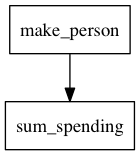

total was 295.46


In [6]:
class MakePerson(Node):
    """
    This node creates a Person Tuple from a csv row
    """
    def process(self, item):
        """
        The .process() method of a node gets called
        exactly once for each item it consumes.
        """
        item['age'] = int(item['age'])
        item['spent'] = float(item['spent'])
        
        # The .push() method sends an item to any
        # connected downstream node.  In this case
        # we are pushing an instance of the Person
        # namedtuple.
        self.push(Person(**item))
        
class SumSpending(Node):
    """
    This node aggregates the sum of all items
    passing through it
    """
    def begin(self):
        """
        Nodes can initialize local state in their
        .begin() method.  This state is available
        at each invocation of the .process() method
        """
        self.total = 0
    
    def process(self, item):
        # this just increments the local node total
        # and passes the item along
        self.total += item.spent
        self.push(item)
        
    def end(self):
        """
        Nodes can summarize and tear down local state
        in their .end() methods. Note that, although we
        don't call .push() from inside this example
        .end() method, doing so is the recommended way
        of pushing summary information to downstream nodes.
        """
        print('total was {}'.format(self.total))
        
            
# Here we wire our nodes into a pipeline.  The syntax for
# doing this is inspired by pipes in bash
pipe = Pipeline(
    MakePerson('make_person') | SumSpending('sum_spending') 
)

# At any point after creating it, you can visualize your
# pipeline by calling the .plot() method, which will draw
# a directed-graph representation either to file or displayed
# in an IPython notebook.
pipe.plot(display_notebook=True)
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

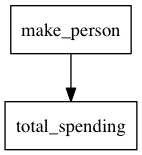

sum for total_spending was 300.04


In [5]:
class MakePerson(Node):
    def process(self, item):
        item['age'] = int(item['age'])
        item['spent'] = float(item['spent'])
        self.push(Person(**item))
        
class SumSpending(Node):
    def begin(self):
        self.total = 0
    def process(self, item):
        self.total += item.spent
    def end(self):
        print('sum for {} was {}'.format(self.name, self.total))
        
            
pipe = Pipeline(
    MakePerson('make_person') | SumSpending('total_spending') 
)
pipe.plot(display_notebook=True)
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

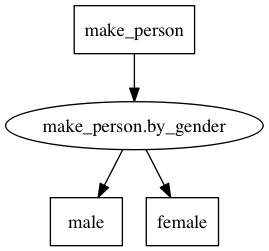

sum for male was 120.65
sum for female was 179.39


In [6]:
class MakePerson(Node):
    def process(self, item):
        item['age'] = int(item['age'])
        item['spent'] = float(item['spent'])
        self.push(Person(**item))
        
class SumSpending(Node):
    def begin(self):
        self.total = 0
    def process(self, item):
        self.total += item.spent
    def end(self):
        print('sum for {} was {}'.format(self.name, self.total))

def by_gender(item):
    return '{}'.format(item.gender)
    
            
pipe = Pipeline(
    MakePerson('make_person') | [SumSpending('male'), SumSpending('female'), by_gender] 
)
pipe.plot(display_notebook=True)
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

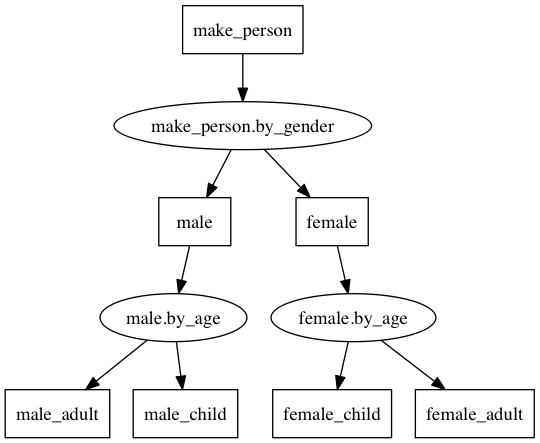

sum for male was 120.65
sum for male_child was 57.9
sum for male_adult was 62.75
sum for female was 179.39
sum for female_child was 36.46
sum for female_adult was 142.93


In [7]:
class MakePerson(Node):
    def process(self, item):
        item['age'] = int(item['age'])
        item['spent'] = float(item['spent'])
        self.push(Person(**item))
        
class SumSpending(Node):
    def begin(self):
        self.total = 0
    def process(self, item):
        self.total += item.spent
        self.push(item)
    def end(self):
        print('sum for {} was {}'.format(self.name, self.total))

def by_gender(item):
    return '{}'.format(item.gender)

def by_age(item):
    if item.age >= 18:
        return '{}_adult'.format(item.gender)
    else:
        return '{}_child'.format(item.gender)
    

pipe = Pipeline(
    MakePerson('make_person') | 
    [
        (SumSpending('male') | [SumSpending('male_child'), SumSpending('male_adult'), by_age]),
        (SumSpending('female') | [SumSpending('female_child'), SumSpending('female_adult'), by_age]),
        by_gender
    ]

)
pipe.plot(display_notebook=True)
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

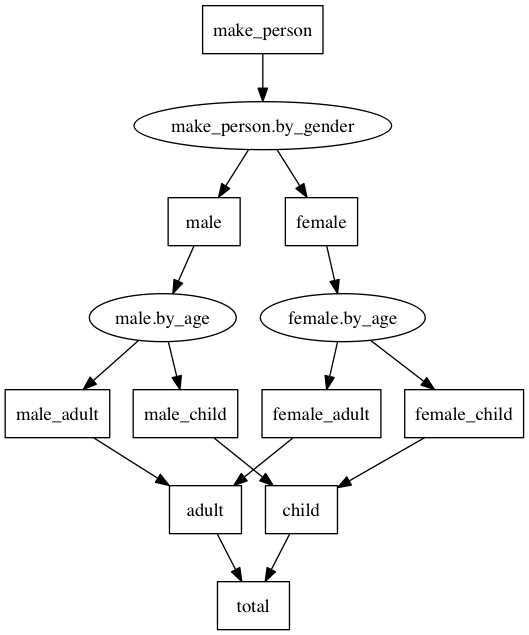

sum for male was 120.65
sum for male_child was 57.9
sum for male_adult was 62.75
sum for female was 179.39
sum for female_child was 36.46
sum for child was 94.36
sum for female_adult was 142.93
sum for adult was 205.68
sum for total was 300.04


In [8]:
class MakePerson(Node):
    def process(self, item):
        item['age'] = int(item['age'])
        item['spent'] = float(item['spent'])
        self.push(Person(**item))
        
class SumSpending(Node):
    def begin(self):
        self.total = 0
    def process(self, item):
        self.total += item.spent
        self.push(item)
    def end(self):
        print('sum for {} was {}'.format(self.name, self.total))

def by_gender(item):
    return '{}'.format(item.gender)

def by_age(item):
    if item.age >= 18:
        return '{}_adult'.format(item.gender)
    else:
        return '{}_child'.format(item.gender)
    
adult = SumSpending('adult')
child = SumSpending('child')
total = SumSpending('total')

adult.add_downstream(total)
child.add_downstream(total)

pipe = Pipeline(
    MakePerson('make_person') | 
    [
        (SumSpending('male') | [SumSpending('male_child'), SumSpending('male_adult'), by_age]),
        (SumSpending('female') | [SumSpending('female_child'), SumSpending('female_adult'), by_age]),
        by_gender
    ]
)
pipe['male_child'].add_downstream(child)
pipe['female_child'].add_downstream(child)
pipe['male_adult'].add_downstream(adult)
pipe['female_adult'].add_downstream(adult)


pipe.plot(display_notebook=True)
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))

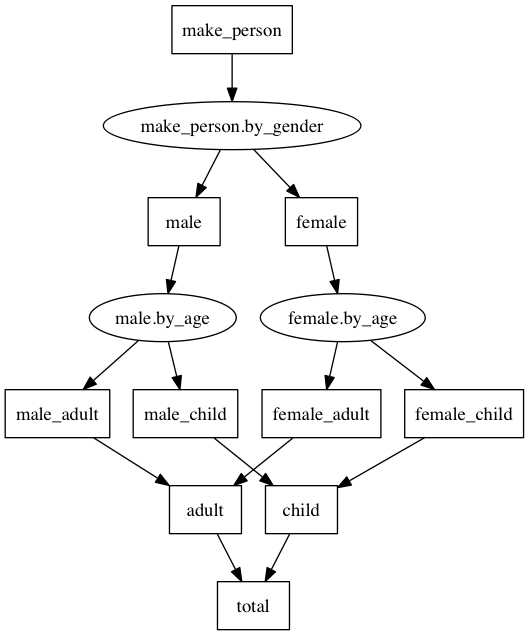

sum for male was 120.65
sum for male_child was 57.9
sum for male_adult was 62.75
sum for female was 179.39
sum for female_child was 36.46
sum for child was 94.36
sum for female_adult was 142.93
sum for adult was 205.68
sum for total was 300.04

{'adult': 205.68000000000004,
 'child': 94.36,
 'female': 179.39000000000001,
 'female_adult': 142.93,
 'female_child': 36.46,
 'male': 120.64999999999999,
 'male_adult': 62.75,
 'male_child': 57.9,
 'total': 300.03999999999996}


In [17]:
class MakePerson(Node):
    def process(self, item):
        item['age'] = int(item['age'])
        item['spent'] = float(item['spent'])
        self.push(Person(**item))
        
class SumSpending(Node):
    def begin(self):
        self.total = 0
    def process(self, item):
        self.total += item.spent
        self.push(item)
    def end(self):
        print('sum for {} was {}'.format(self.name, self.total))
        self.global_state.segment_totals[self.name] = self.total

def by_gender(item):
    return '{}'.format(item.gender)

def by_age(item):
    if item.age >= 18:
        return '{}_adult'.format(item.gender)
    else:
        return '{}_child'.format(item.gender)
    
adult = SumSpending('adult')
child = SumSpending('child')
total = SumSpending('total')

adult.add_downstream(total)
child.add_downstream(total)

pipe = Pipeline(
    MakePerson('make_person') | 
    [
        (SumSpending('male') | [SumSpending('male_child'), SumSpending('male_adult'), by_age]),
        (SumSpending('female') | [SumSpending('female_child'), SumSpending('female_adult'), by_age]),
        by_gender
    ],
    global_state=GlobalState(segment_totals={})
)
pipe['male_child'].add_downstream(child)
pipe['female_child'].add_downstream(child)
pipe['male_adult'].add_downstream(adult)
pipe['female_adult'].add_downstream(adult)


pipe.plot(display_notebook=True)
with open('age_gender.csv') as f:
    pipe.consume(csv.DictReader(f))
print()
pprint(pipe.global_state.segment_totals)